In [ ]:
!nvidia-smi

## 1) Installing libraries

In [1]:
# !pip install transformers
# !pip install datasets
# !pip install wandb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [3]:
# enter your personal read token

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/total_code_mixed", use_auth_token=True)

print(aggression_dataset)

Using custom data configuration IIIT-L--total_code_mixed-c86de67ddd2696fa
Reusing dataset csv (/home/diptesh/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--total_code_mixed-c86de67ddd2696fa/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 3976
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 497
    })
})


In [6]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 3976
})

## 3) Converting to dataframe

In [7]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,We don't spend one hour and rush off from our ...,1
1,Shivani my classmate,0
2,True reviewerÃƒÂ°Ã…Â¸Ã¢â€žÂ¢Ã‚Â,0
3,Royal C***yas Bangalore ÃƒÂ°Ã…Â¸Ã‹Å“Ã¢â‚¬Å¡ÃƒÂ...,2
4,*PURE DESH ME AFRA TAFRI KA MAHOOL HAI...INDIA...,2


In [8]:
test_df = aggression_dataset['test'][:]

In [9]:
train_df['Label'].value_counts()

0    2137
1    1086
2     753
Name: Label, dtype: int64

In [10]:
# 3976
# NAG-CAG-OAG (0-1-2) = 0.54-0.27-0.19

Seeing Distribution

In [11]:
disb_df = train_df.copy(deep=True)

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


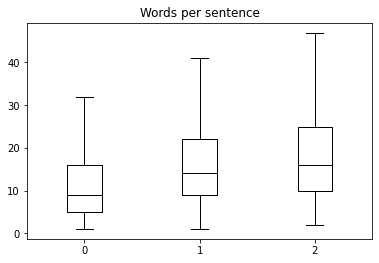

In [12]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [13]:
from transformers import AutoTokenizer

In [14]:
model_ckpt = 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer.vocab_size

50265

In [16]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [17]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=510)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=510)

In [19]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [21]:
import torch

In [22]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [23]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [25]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: diptesh. Use `wandb login --relogin` to force relogin


True

In [26]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [27]:
from transformers import Trainer, TrainingArguments

In [28]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-code-mixed-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=1e-05,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.01,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="roberta-large-code-mixed-DS",
                                  push_to_hub=True)

In [29]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [30]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.17, 0.27, 0.56]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [31]:
from transformers import EarlyStoppingCallback

In [32]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [33]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        # callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /home/diptesh/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",

  0%|          | 0/2490 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.9813, 'learning_rate': 9.004016064257028e-06, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-248
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-248/config.json


{'eval_loss': 0.8132907748222351, 'eval_accuracy': 0.6197183098591549, 'eval_precision': 0.5679188034188034, 'eval_recall': 0.5796921167064323, 'eval_f1': 0.5138948656434917, 'eval_runtime': 5.3597, 'eval_samples_per_second': 92.729, 'eval_steps_per_second': 2.985, 'epoch': 1.0}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-248/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-248/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-248/special_tokens_map.json
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.7795, 'learning_rate': 8.008032128514057e-06, 'epoch': 1.99}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-496
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-496/config.json


{'eval_loss': 0.7135039567947388, 'eval_accuracy': 0.7183098591549296, 'eval_precision': 0.6739366601904377, 'eval_recall': 0.6962690566704012, 'eval_f1': 0.6781552436663217, 'eval_runtime': 5.308, 'eval_samples_per_second': 93.632, 'eval_steps_per_second': 3.014, 'epoch': 1.99}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-496/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-496/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-496/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.6188, 'learning_rate': 7.012048192771085e-06, 'epoch': 2.99}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-744
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-744/config.json


{'eval_loss': 0.7417853474617004, 'eval_accuracy': 0.7323943661971831, 'eval_precision': 0.6726127478659448, 'eval_recall': 0.6859823218473778, 'eval_f1': 0.6760741183519231, 'eval_runtime': 5.3291, 'eval_samples_per_second': 93.261, 'eval_steps_per_second': 3.002, 'epoch': 2.99}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-744/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-744/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-744/special_tokens_map.json
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.4741, 'learning_rate': 6.016064257028112e-06, 'epoch': 3.98}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-992
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-992/config.json


{'eval_loss': 0.8716133236885071, 'eval_accuracy': 0.7122736418511066, 'eval_precision': 0.6495062243026845, 'eval_recall': 0.6614725179258092, 'eval_f1': 0.6501053260736401, 'eval_runtime': 5.3675, 'eval_samples_per_second': 92.594, 'eval_steps_per_second': 2.981, 'epoch': 3.98}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-992/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-992/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-992/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.3326, 'learning_rate': 5.0200803212851415e-06, 'epoch': 4.98}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-1240
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1240/config.json


{'eval_loss': 1.143674373626709, 'eval_accuracy': 0.716297786720322, 'eval_precision': 0.6501666160110183, 'eval_recall': 0.6470055031335987, 'eval_f1': 0.6475010038557737, 'eval_runtime': 5.2858, 'eval_samples_per_second': 94.026, 'eval_steps_per_second': 3.027, 'epoch': 4.98}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1240/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1240/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1240/special_tokens_map.json
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.2636, 'learning_rate': 4.024096385542169e-06, 'epoch': 5.98}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-1488
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1488/config.json


{'eval_loss': 1.3625705242156982, 'eval_accuracy': 0.7263581488933601, 'eval_precision': 0.6832000417425622, 'eval_recall': 0.6582518097684528, 'eval_f1': 0.6586688131964739, 'eval_runtime': 5.2567, 'eval_samples_per_second': 94.547, 'eval_steps_per_second': 3.044, 'epoch': 5.98}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1488/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1488/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1488/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.1783, 'learning_rate': 3.028112449799197e-06, 'epoch': 6.97}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-1736
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1736/config.json


{'eval_loss': 1.555370807647705, 'eval_accuracy': 0.744466800804829, 'eval_precision': 0.6957910617013953, 'eval_recall': 0.6832737238651935, 'eval_f1': 0.6822560068743599, 'eval_runtime': 5.2301, 'eval_samples_per_second': 95.027, 'eval_steps_per_second': 3.059, 'epoch': 6.97}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1736/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1736/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1736/special_tokens_map.json
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.1258, 'learning_rate': 2.032128514056225e-06, 'epoch': 7.97}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-1984
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1984/config.json


{'eval_loss': 1.6650152206420898, 'eval_accuracy': 0.7404426559356136, 'eval_precision': 0.6772554171626552, 'eval_recall': 0.673131911143611, 'eval_f1': 0.6746745140003566, 'eval_runtime': 5.2769, 'eval_samples_per_second': 94.185, 'eval_steps_per_second': 3.032, 'epoch': 7.97}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1984/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1984/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-1984/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.099, 'learning_rate': 1.0361445783132532e-06, 'epoch': 8.96}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-2232
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2232/config.json


{'eval_loss': 1.8831099271774292, 'eval_accuracy': 0.7303822937625755, 'eval_precision': 0.6636580577220814, 'eval_recall': 0.662186972167144, 'eval_f1': 0.6626640636493403, 'eval_runtime': 5.2521, 'eval_samples_per_second': 94.629, 'eval_steps_per_second': 3.046, 'epoch': 8.96}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2232/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2232/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2232/special_tokens_map.json
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 497
  Batch size = 32


{'loss': 0.0932, 'learning_rate': 4.016064257028112e-08, 'epoch': 9.96}


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS/checkpoint-2480
Configuration saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2480/config.json


{'eval_loss': 2.0032413005828857, 'eval_accuracy': 0.7344064386317908, 'eval_precision': 0.6701497735980494, 'eval_recall': 0.6681840518500809, 'eval_f1': 0.6687592364653706, 'eval_runtime': 5.3653, 'eval_samples_per_second': 92.632, 'eval_steps_per_second': 2.982, 'epoch': 9.96}


Model weights saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2480/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2480/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/checkpoint-2480/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from roberta-large-finetuned-code-mixed-DS/checkpoint-1736 (score: 0.6822560068743599).


{'train_runtime': 2300.8108, 'train_samples_per_second': 17.281, 'train_steps_per_second': 1.082, 'train_loss': 0.393287586280141, 'epoch': 10.0}


eval/accuracy,▁▇▇▆▆▇██▇▇
eval/f1,▁██▇▇▇██▇▇
eval/loss,▂▁▁▂▃▅▆▆▇█
eval/precision,▁▇▇▅▆▇█▇▆▇
eval/recall,▁█▇▆▅▆▇▇▆▆
eval/runtime,█▅▆█▄▂▁▃▂█
eval/samples_per_second,▁▄▃▁▅▇█▆▇▁
eval/steps_per_second,▁▄▃▁▅▇█▆▇▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁


In [34]:
trainer.push_to_hub()

Saving model checkpoint to roberta-large-finetuned-code-mixed-DS
Configuration saved in roberta-large-finetuned-code-mixed-DS/config.json
Model weights saved in roberta-large-finetuned-code-mixed-DS/pytorch_model.bin
tokenizer config file saved in roberta-large-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-large-finetuned-code-mixed-DS/special_tokens_map.json
remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/dipteshkanojia/roberta-large-finetuned-code-mixed-DS
   f190cad..edcaa28  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7344064386317908}, {'name': 'Precision', 'type': 'precision', 'value': 0.6701497735980494}, {'name': 'Recall', 'type': 'recall', 'value': 0.6681840518500809}, {'name': 'F

'https://huggingface.co/dipteshkanojia/roberta-large-finetuned-code-mixed-DS/commit/edcaa28b4f36b302b47095e1e3f6441aca7f5174'

## 8) Predictions and Results

In [35]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [36]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=510)

In [37]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [38]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 498
  Batch size = 32
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/16 [00:00<?, ?it/s]

In [39]:
preds_output_test.metrics

{'test_loss': 1.3655140399932861,
 'test_accuracy': 0.7469879518072289,
 'test_precision': 0.7058170923526328,
 'test_recall': 0.6984103263407618,
 'test_f1': 0.6977407291820255,
 'test_runtime': 5.329,
 'test_samples_per_second': 93.451,
 'test_steps_per_second': 3.002}

In [40]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [41]:
y_valid_test = np.array(test_dataset.labels)

In [42]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [43]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.89      0.83      0.86       268
         CAG       0.58      0.72      0.64       136
         OAG       0.65      0.54      0.59        94

    accuracy                           0.75       498
   macro avg       0.71      0.70      0.70       498
weighted avg       0.76      0.75      0.75       498



In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

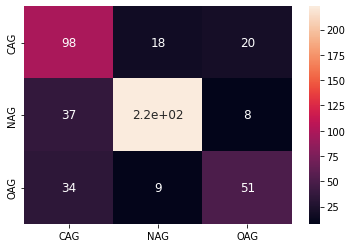

In [45]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 